In [240]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import random
import matplotlib.pyplot as plt

In [241]:
import requests
from bs4 import BeautifulSoup
import re

# Specify the URL
url = 'https://www.mrao.cam.ac.uk/surveys/snrs/snrs.data.html'

# Fetch the content from the URL
response = requests.get(url, verify=False)
content = response.content

# Parse the content with BeautifulSoup
soup = BeautifulSoup(content, 'html.parser')

pre_tag = soup.find('pre')

pre_contents = pre_tag.text



/Users/dmitryzenko/miniconda3/envs/cm21fast/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.mrao.cam.ac.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [242]:
lines = pre_contents.strip().split("\n")
lines = [element for element in lines if element]

lines_val = lines[4:-1]

In [243]:
'''spectral_idx = []

# Process each line
for line in lines[4:-1]:  # skipping the header line
    
    columns = re.split(r' {2,}', line) 
    #spectral_idx.append(columns[8])
    if columns[0]=='':
        columns.remove(columns[0])
    
    if len(columns)==9:
        columns.remove(columns[-1])
    
    spectral_idx.append(columns[-1])'''

"spectral_idx = []\n\n# Process each line\nfor line in lines[4:-1]:  # skipping the header line\n    \n    columns = re.split(r' {2,}', line) \n    #spectral_idx.append(columns[8])\n    if columns[0]=='':\n        columns.remove(columns[0])\n    \n    if len(columns)==9:\n        columns.remove(columns[-1])\n    \n    spectral_idx.append(columns[-1])"

In [244]:
dist_max = 10185.42355352
dist_min = 9132.09022019

box_len = 2000

theta_max = np.arctan((box_len/2)/dist_max)
theta_min = np.arctan((box_len/2)/dist_min)

angle_max = 2 * (theta_max*180/np.pi)
angle_min = 2 * (theta_min*180/np.pi)

print(angle_min)
print(angle_max)

12.498431001065951
11.214603133830998


In [245]:
snr_in_5x5 = 1.5

snr_in_angle = int(np.round((snr_in_5x5/25)*angle_max**2))
snr_in_angle

8

In [246]:
grid = 2000

canvas = np.zeros((grid, grid))

random_points = [(random.randint(0, grid-1), random.randint(0, grid-1)) for _ in range(snr_in_angle)]
random_points



[(48, 1147),
 (1586, 1737),
 (1537, 186),
 (897, 1097),
 (997, 1743),
 (1920, 831),
 (340, 1503),
 (117, 1674)]

In [247]:
amnt_of_samples = len(lines_val) # amount of specimen
amnt_of_samples

303

In [248]:
sample_idx = [random.randint(0, 302) for _ in range(snr_in_angle)]
sample_idx

[76, 133, 189, 80, 173, 72, 29, 147]

In [260]:
a_values_list = []
b_values_list = []
flux_values_list = []

for i in sample_idx:

    test_line = lines_val[i]

    if '?' in test_line:
        test_line = test_line.replace('?','')


    columns = re.split(r' {2,}| (?=[+ - S F C])', test_line)
    if columns[0]=='':
            columns.remove(columns[0])

    print(columns)

    ang_size = columns[4] 
    flux = columns[6]
    
    

    if '>' in flux:
        flux = flux.replace('>','')
    
    if flux.strip() == '':
            flux = 7 # random value, can be substituted by mean/mode value from the column
    
    

    if 'x' in ang_size:
        a = float(ang_size.split('x')[0])
        b = float(ang_size.split('x')[1])
    else:
        r = float(ang_size)
        a = r
        b = r

    a_values_list.append(a/2)
    b_values_list.append(b/2)
    flux_values_list.append(float(flux))

['28.6', '-0.1', '18 43 55', '-03 53', '13x9', 'S', '3', '']
['78.2', '+2.1', '20 20 50', '+40 26', '60', 'S', '320', '0.51', 'DR4, gamma', 'Cygni', 'SNR']
[' 292.2', '-0.5', '11 19 20', '-61 28', '20x15', 'S', '7', '0.5']
['29.7', '-0.3', '18 46 25', '-02 59', '3', 'C', '10', '0.63', 'Kes 75']
[' 205.5', '+0.5', '06 39 00', '+06 30', '220', 'S', '140', '0.4', 'Monoceros Nebula']
['25.1', '-2.3', '18 45 10', '-08 00', '80x30', 'S', '8', '0.5']
['9.8', '+0.6', '18 05 08', '-20 14', '12', 'S', '3.9', '0.5']
[' 109.1', '-1.0', '23 01 35', '+58 53', '28', 'S', '20', '0.45', 'CTB 109']


In [264]:
max_ang_res = []
for i in range(len(a_values_list)):
    max_ang_res.append(np.max((a_values_list[i], b_values_list[i])))



In [265]:
print(a_values_list)
print(b_values_list)
print(flux_values_list)
print(max_ang_res)

[6.5, 30.0, 10.0, 1.5, 110.0, 40.0, 6.0, 14.0]
[4.5, 30.0, 7.5, 1.5, 110.0, 15.0, 6.0, 14.0]
[3.0, 320.0, 7.0, 10.0, 140.0, 8.0, 3.9, 20.0]
[6.5, 30.0, 10.0, 1.5, 110.0, 40.0, 6.0, 14.0]


In [270]:
def flux_to_brghtnss_temp(freq, flux, max_ang_res):
    """
    freq in GHz
    flux in mJy
    max_and_res in arcsec
    """

    flux = flux*1000 #from Jy to mJy
    freq = freq*0.001 #from MHz to GHz
    max_ang_res = np.array(max_ang_res*60) #from arcmin to arcsec

    T = 1.222 * 10**3 * (flux/(freq**2 * max_ang_res**2)) # in K

    return T

In [272]:
T = flux_to_brghtnss_temp(157.78, np.array(flux_values_list), np.array(max_ang_res))
print(T)

[  968.18721429  4848.10782857   954.47122875 60601.34785717
   157.76383946    68.17651634  1477.15785402  1391.35747631]


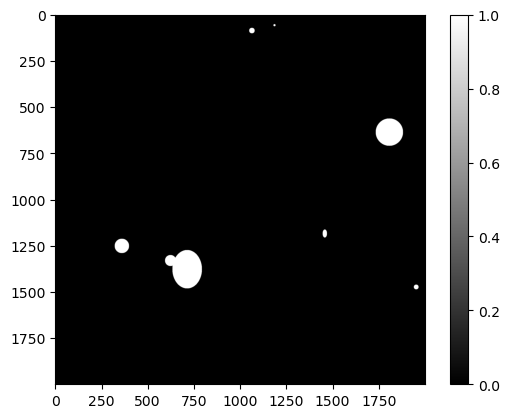

In [143]:
def draw_multiple_ellipses_on_grid(coordinates, a_values, b_values, angle_max, grid_size):
    """
    Draw multiple ellipses on a grid.

    :param coordinates: List of tuples (x, y) for the center of each ellipse.
    :param a_values: List of semi-major axes in arcminutes for each ellipse.
    :param b_values: List of semi-minor axes in arcminutes for each ellipse.
    :param angle_max: Angular size of the canvas in degrees.
    :param grid_size: Size of the grid.
    :return: A grid with multiple ellipses drawn.
    """
    # Convert the angular size of the canvas to arcminutes (1 degree = 60 arcminutes)
    canvas_angular_size_arcminutes = angle_max * 60

    # Scale factor: number of pixels per arcminute
    scale_factor = grid_size / canvas_angular_size_arcminutes

    # Create an empty grid
    grid = np.zeros((grid_size, grid_size))

    for (center_x, center_y), a, b in zip(coordinates, a_values, b_values):
        # Convert ellipse dimensions to grid units
        semi_major_axis_pixels = int(round(a * scale_factor))
        semi_minor_axis_pixels = int(round(b * scale_factor))

        # Calculate the range for the ellipse in both x and y directions
        x_range = np.arange(center_x - semi_minor_axis_pixels, center_x + semi_minor_axis_pixels + 1)
        y_range = np.arange(center_y - semi_major_axis_pixels, center_y + semi_major_axis_pixels + 1)

        # Ensure the ranges are within the grid boundaries
        x_range = x_range[(x_range >= 0) & (x_range < grid_size)]
        y_range = y_range[(y_range >= 0) & (y_range < grid_size)]

        # Fill pixels within the ellipse
        for x_pixel in x_range:
            for y_pixel in y_range:
                if ((x_pixel - center_x)**2 / semi_minor_axis_pixels**2 + 
                    (y_pixel - center_y)**2 / semi_major_axis_pixels**2) <= 1:
                    grid[y_pixel, x_pixel] = 1

    return grid

# Example usage with a list of coordinates and corresponding dimensions
coordinates_list = random_points


# Draw the ellipses
multiple_ellipse_grid = draw_multiple_ellipses_on_grid(random_points, a_values_list, b_values_list, angle_max, grid)


# Plotting
plt.imshow(multiple_ellipse_grid, cmap='gray')
plt.colorbar()
plt.show()